# Test Technique : Système de recommendation d'offres d'emploi à des candidats
On cherche à recommender des offres d'emploi à des candidats identifiés respectivement par leurs *jobID* et *userID*. Pour cela, on dispose de:
- un fichier jobs.cv: descrption des différents offres d'emplois
- un fichier users.csv : description des profils des candidats 
- un fichier users_history.csv qui répertorie l'historique de certains candidats 
- un fichier feedback.csv qui rensigne sur les interactions des candidats avec les annonces 
- un fichier test_users.csv sur lequel on cherche à faire les recommendations d'emplois

On propose un système de recommendation qui s'appuie sur les interactions *usersID* et *jobsID* issus du fichier feedback.csv. Ces interactions étant sous la forme d'évenements ( *viewed*, *applied* et *hired*), il nous faut alors tenir compte de l'aspect **implicite** des feedbacks. C'est pourquoi, on a choisi une approche de type **Collaborative FIltering** en implémentant la méthode **ALS** (*Alternating Least Squares*)  de la librairie implicit pour modéliser les interactions users-jobs. 
Ensuite, ne disposant pas de feedbacks pour les candidats issus du fichier test_users.csv, on utilise certains features pertinents pour trouver des similitudes entre les candidats test et les candidats du fichier users.csv. On effectue cette mesure de similitude avec **cosine_similarity** de sklearn.

## Structure du notebook

 1) Exploratory data analysis 
 2) Correspondances entre les candidats test et les candidats de "training"
 3) Implémentation du modèle de recommendation: entrainement sur les données d'interactions et recommendations sur les candidats tests 
 4) Evaluation des performances du modèle et discussion des limites


## Importing useful librairies

In [1]:
import implicit  # for tackling implicit feedback in Collaborative Filtering 
import os
import ml_metrics
import matplotlib

import pandas            as pd  # to store data 
import numpy             as np  

# For Plotting purposes : 
import seaborn           as sns
import matplotlib.pyplot as plt 
import plotly.graph_objs as go

import scipy.sparse      as sparse

from plotly.offline                  import init_notebook_mode, plot, iplot
from sklearn.model_selection         import train_test_split
from sklearn.preprocessing           import OneHotEncoder, StandardScaler
from sklearn.cluster                 import KMeans 
from sklearn.metrics.pairwise        import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

init_notebook_mode(connected=True)

## 1) Exploratory Data Analysis
Loading datasets: 

In [2]:
data_jobs     = pd.read_csv('./test-technique-data/data/jobs.csv')
data_user     = pd.read_csv('./test-technique-data/data/users.csv')
data_feedback = pd.read_csv('./test-technique-data/data/feedbacks.csv')
data_history  = pd.read_csv('./test-technique-data/data/users_history.csv')
data_test     = pd.read_csv('./test-technique-data/data/test_users.csv')

Dans la suite, on utilisera les candidates issus de data_user pour l'entrainement du modèle et les candidats issus de data_test pour les recommendations 

In [3]:
print(' The dataset jobs.csv: \n')
print(f' Number of rows: {data_jobs.shape[0]}\n Number of columns: {data_jobs.shape[1]} \n')
print(' The dataset users.csv: \n')
print(f' Number of rows: {data_user.shape[0]}\n Number of columns: {data_user.shape[1]} \n')
print(' The dataset feedback.csv: \n')
print(f' Number of rows: {data_feedback.shape[0]}\n Number of columns: {data_feedback.shape[1]}\n')
print(' The dataset history.csv: \n')
print(f' Number of rows: {data_history.shape[0]}\n Number of columns: {data_history.shape[1]}')
print(f'Number of users that have left a feedback {len(data_feedback.UserID.unique())}')

 The dataset jobs.csv: 

 Number of rows: 4291
 Number of columns: 11 

 The dataset users.csv: 

 Number of rows: 2337
 Number of columns: 14 

 The dataset feedback.csv: 

 Number of rows: 28928
 Number of columns: 3

 The dataset history.csv: 

 Number of rows: 11012
 Number of columns: 4
Number of users that have left a feedback 1861


In [4]:
print('Number of different jobs: ', len(data_jobs.JobID.unique()))
print('Number of different jobs categories : ', len(data_jobs.JobCategoryID.unique()))

print('Number of different registred users: ', len(data_user.UserID.unique()))
print('Number of different users in feedback.csv: ', len(data_feedback.UserID.unique()))
print('Number of different jobs in feedback.csv: ', len(data_feedback.JobID.unique()))
print('Number of different users in history.csv: ', len(data_history.UserID.unique()))
print(f'{len(data_feedback.UserID.unique())/ len(data_user.UserID.unique()) * 100:.2f} % of registred candidates have a feedback')

Number of different jobs:  4291
Number of different jobs categories :  195
Number of different registred users:  2337
Number of different users in feedback.csv:  1861
Number of different jobs in feedback.csv:  3149
Number of different users in history.csv:  2509
79.63 % of registred candidates have a feedback


Dans users.csv, chaque ligne correspond à un candidat différent. De même pour jobs.csv où chaque ligne renvoie à un job différent. Environ $80 \%$ des candidats ont laissé un feedback sur les offres d'emploi.


In [5]:
print('Number of missing values in jobs.csv:\n',data_jobs.isnull().sum(), '\n')

print('Number of missing values in users.csv:\n',data_user.isnull().sum(), '\n')
print('Number of missing values in feedbacks.csv:\n',data_feedback.isnull().sum(), '\n')

print('Number of missing values in user_history.csv:\n',data_history.isnull().sum())


Number of missing values in jobs.csv:
 JobID               0
Title               0
Description         0
Requirements      266
City                0
State               0
Country             0
Zip5             1195
StartDate           0
EndDate             0
JobCategoryID       0
dtype: int64 

Number of missing values in users.csv:
 UserID                    0
City                      0
State                     0
Country                   0
ZipCode                   2
DegreeType                0
Major                   588
GraduationDate          705
WorkHistoryCount          0
TotalYearsExperience     77
CurrentlyEmployed       322
ManagedOthers             0
ManagedHowMany            0
MajorCategoryID         588
dtype: int64 

Number of missing values in feedbacks.csv:
 UserID    0
JobID     0
Event     0
dtype: int64 

Number of missing values in user_history.csv:
 UserID           0
Sequence         0
JobTitle         0
JobCategoryID    0
dtype: int64


A présent, on s'interesse à la distribution des catégories d'emploi au sein des offres:

Text(0.5, 1.0, 'Distribution of the jobs categories')

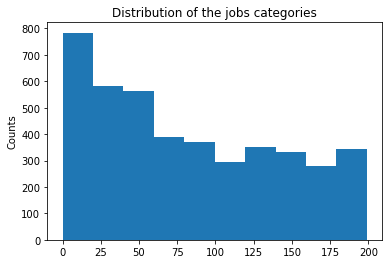

In [6]:
JobCatDic = {}
for jobCat in np.sort(data_jobs.JobCategoryID.value_counts().index):
    index  = np.where(data_jobs.JobCategoryID==jobCat)
    JobCatDic[jobCat] =  data_jobs.JobID.iloc[index].values.tolist()
data_jobs.JobCategoryID.value_counts()

ax = data_jobs.JobCategoryID.hist(grid=False)
ax.set_ylabel('Counts')
ax.set_title('Distribution of the jobs categories')

On peut comparer cette distribution avec celle qui ressort de l'historique des candidats 

Text(0.5, 1.0, 'Distribution of the jobs categories')

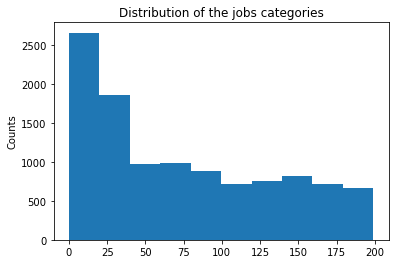

In [7]:
data_history.JobCategoryID.value_counts()

ax = data_history.JobCategoryID.hist(grid=False)
ax.set_ylabel('Counts')
ax.set_title('Distribution of the jobs categories')

La distribution des offres d'emploi dans l'historique des candidats reflète celle issue du fichier jobs.csv. Certaines catégories sont sruprésentées dans les deux cas. 


On regarde à présent la distribution des feedbacks 

In [8]:
data_feedback.Event.value_counts().index

Index(['viewed', 'applied', 'hired'], dtype='object')

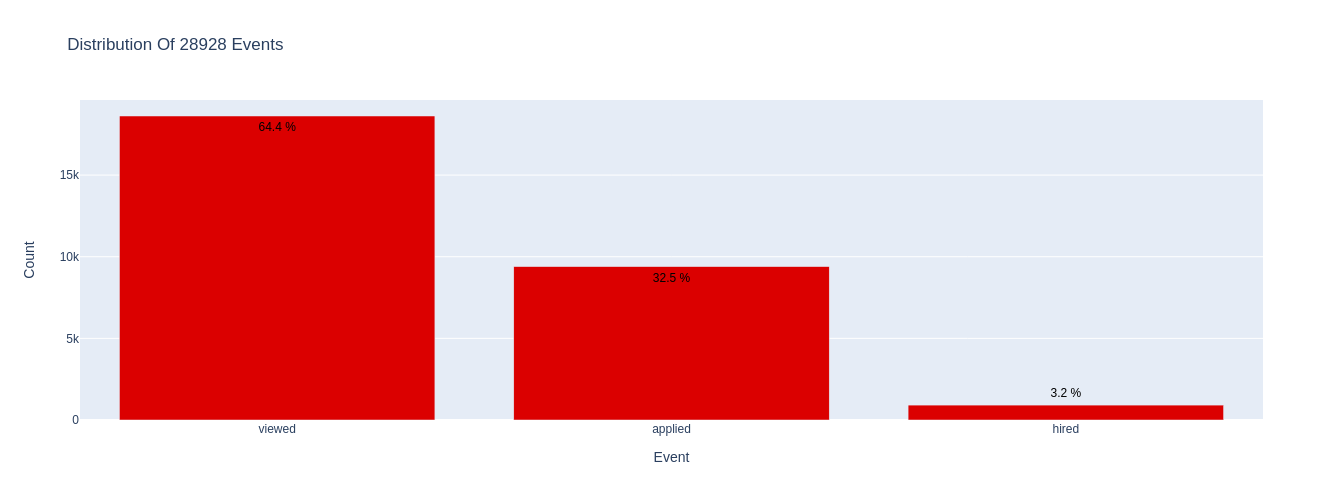

In [9]:
#print('Different types of Event \n', data_feedback.Event.value_counts())
import plotly.offline as py
bar = go.Bar(x = data_feedback.Event.value_counts().index,
               text = ['{:.1f} %'.format(val) for val in (data_feedback.Event.value_counts().values / data_feedback.shape[0] * 100)],
               textposition = 'auto',
               textfont = dict(color = '#000000'),
               y = data_feedback.Event.value_counts().values ,
               marker = dict(color = '#db0000'))
# Create layout
layout = dict(title = 'Distribution Of {} Events '.format(data_feedback.shape[0]),
              xaxis = dict(title = 'Event'),
              yaxis = dict(title = 'Count'))

# Create plot
fig = go.Figure(data=[bar], layout=layout)
fig.update_layout(
    autosize=False,
    width=500,
    height=500,)
iplot(fig)

#ax = data_fbeedback.Event.hist(grid=False)
#ax.set_ylabel('Counts')

The number of interactions per candidate is 15.54


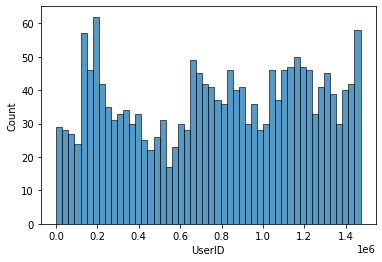

In [10]:
# nombre d'evt par utilisateurs 
interactions     = pd.DataFrame(data_feedback.groupby('UserID')['Event'].count()).reset_index(level=0)
mean_interaction = interactions.Event.mean()
sns.histplot(data=interactions, x='UserID', stat="count", bins=50)
#a = ((np.sort(data_feedback.UserID.values.tolist())))

print(f'The number of interactions per candidate is {mean_interaction:.2f}' )

On s'aperçoit que la plupart des candidats interagissent avec plusieurs offres différentes, parfois plusieurs fois avec la même.

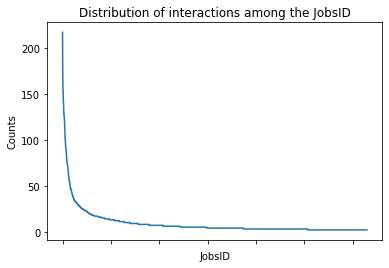

Seul  2.51% des offres d'emploi comptabilisent plus de 50 évenements


In [11]:
# mesure de la popularité des offres d'emploi  
popularity  = pd.DataFrame(data_feedback.groupby('JobID')['Event'].count()).reset_index(level=0)
popularity  = popularity.sort_values('Event', ascending=False)
popularity  = popularity.reset_index()
popularity
#mean_interaction = popularity.Event.mean()
ax = plt.gca()
ax.axes.xaxis.set_ticklabels([])
ax.set_title('Distribution of interactions among the JobsID')
plt.plot(popularity.index.tolist(), popularity.Event.tolist())
plt.xlabel('JobsID')
plt.ylabel('Counts')
plt.show()
print(f'Seul {len(popularity.loc[popularity.Event>50])/len(popularity)* 100: .2f}% des offres d\'emploi comptabilisent plus de 50 évenements')
#sns.plot(data=popularity,y= 'Event', stat="count", bins=50)
#a = ((np.sort(data_feedback.UserID.values.tolist())))

#print(f'The number of interactions per candidate is {mean_interaction:.2f}' )

Une partie infime des offres d'emploi ($2,5 \%$) recueillent plus de 50 interactions avec les utilisateurs 

## 2) Similitude between users of test and users of training

In [12]:
data_user = data_user.drop(columns= ['Country','City', 'State', 'ZipCode', 'GraduationDate', 'CurrentlyEmployed'])
data_test = data_test.drop(columns= ['Country','City', 'State', 'ZipCode', 'GraduationDate', 'CurrentlyEmployed'])

In [13]:
data_all = pd.concat([data_user, data_test])
data_all.Major = data_all.Major.fillna("")
data_all.MajorCategoryID = data_all.MajorCategoryID.fillna("")
data_all.ManagedOthers.value_counts()

No     1860
Yes     754
Name: ManagedOthers, dtype: int64

In [14]:
def combined_features(row):
    return row['DegreeType']+" "+row['Major']+" "+row['ManagedOthers']+" "+ str(row['MajorCategoryID'])

data_all["combined_features"] = data_all.apply(combined_features, axis =1)

cv = CountVectorizer()
count_matrix = cv.fit_transform(data_all["combined_features"])
#print("Count Matrix:", count_matrix.toarray())
cos = cosine_similarity(count_matrix)

# Recherche du candidat du training le plus proche pour chaque candidat du dataset test


max_index = []
for i in np.arange(2337, len(data_all)):
    row = np.array(cos[i,:])[:2337]
    max_index.append(np.argmax(row))
data_test['UserRefID'] = [data_user.iloc[i].UserID for i in max_index]
data_test

,UserID,DegreeType,Major,WorkHistoryCount,TotalYearsExperience,ManagedOthers,ManagedHowMany,MajorCategoryID,UserRefID
0,12924,Bachelor's,NaN,4,9.0,No,0,NaN,66137
1,18947,None,NaN,6,22.0,No,0,NaN,698
2,20976,Master's,NaN,5,6.0,Yes,6,NaN,138206
3,21412,None,Basic Studies,5,5.0,No,0,NaN,698
4,40564,None,NaN,6,5.0,No,0,NaN,698
...,...,...,...,...,...,...,...,...,...
272,1454754,Bachelor's,Accounting & Auditing,7,27.0,No,0,NaN,59593
273,1458384,None,NaN,10,23.0,No,0,NaN,698
274,1458917,Bachelor's,Telecommunications Management,6,6.0,No,0,NaN,201820
275,1466313,Master's,Marketing/Management,8,22.0,No,0,NaN,129835


## 3) Recommendation Engine with ALS

In [15]:
# mapping entre les usersID et les indices -utiles pour la suite 
user_id_mapping = {id:i for i, id in enumerate(data_user['UserID'].unique())}
id_user_mapping = {i:id for i, id in enumerate(data_user['UserID'].unique())}

# mapping entre les JobsID et les indices -utiles pour la suite 
job_id_mapping  = {id:i for i, id in enumerate(np.sort(data_feedback['JobID'].unique()))}
id_job_mapping  = {i:id for i, id in enumerate(np.sort(data_feedback['JobID'].unique()))}


### Construction de la matrice d'interactions *data* à partir de data_feedback

In [16]:
# on convertit les évenemnts en 'rating' en attribuant à l'évenement hired le plus grand score pour dénoter un intérêt maximal.
rating = {'viewed': 1.,
         'applied': 5.,
         'hired':   10.}

Rating = []

data_feedback['Rating'] = data_feedback['Event'].apply(lambda x: rating[x])


data = data_feedback.pivot_table(index='UserID', columns='JobID', aggfunc='max', values='Rating', fill_value=0)
for user in data_user.UserID.values:
    if user not in data_feedback.UserID.values:
        data.loc[user] = pd.Series(index = data.columns.tolist(), data=0 )  
data = data.sort_index()

#  ******************************** Alternative ****************************************** 

#for index,user in enumerate(data_feedback.UserID.unique().tolist()):
#    jobs    = data_feedback.loc[data_feedback.UserID==user].JobID.tolist()
#    ratings = data_feedback.loc[data_feedback.UserID==user].Rating.tolist()
#    for i,job in enumerate(jobs):
#        jobindex = job_id_mapping[job]
#        data[index, jobindex]  = ratings[i]
#data['UserID'] = data['UserID'].apply(column_dict.get)

#  ******************************** For Test purposes Only ******************************************
user = 2305
jobs    = data_feedback.loc[data_feedback.UserID==user].JobID.tolist()
ratings = data_feedback.loc[data_feedback.UserID==user].Rating.tolist()
print(jobs, ratings)
#data.loc[user, 925011] = ratings[6]
data.loc[user][925011]

[573231, 173609, 758183, 796649, 863240, 317319, 925011, 1051415, 925327, 854431, 852315, 46841, 1055037, 925011, 317319, 1051415, 925327, 854431, 852315, 46841, 1055037, 925011] [1.0, 1.0, 1.0, 1.0, 1.0, 5.0, 10.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


10

### Entraînemnt du modèle ALS 

In [17]:
# The two sparse matrix featuring the interactions between users and jobs 

job_users       = sparse.csr_matrix(data.T) # for training
users_jobs      = job_users.T.tocsr()       # for recommendation 

# * ******************************* Training ******************************************

os.environ['MKL_NUM_THREADS']      = '1' #To avoid multithreading.
os.environ['OPENBLAS_NUM_THREADS'] = '1'
model = implicit.als.AlternatingLeastSquares(factors = 500, iterations = 100, regularization=100)
alpha = 40 # from litterature 
#job_users = users_jobs.T.tocsr()
data_confidence = (job_users*alpha)

model.fit(data_confidence)

  0%|          | 0/100 [00:00<?, ?it/s]

### Recommendations du modèle

Sur le dataset de training: 

In [18]:
Index   = np.arange(np.shape(users_jobs)[0])
jobsTraining, scoresTraining = model.recommend(Index, users_jobs[Index], N = 50, filter_already_liked_items=False)

Sur le dataset de test: 

In [19]:
usersId     = data_test.UserRefID
usersIndex  = [user_id_mapping[users] for users in usersId ]
jobsTest, scoresTest = model.recommend(usersIndex, users_jobs[usersIndex], N = 1, filter_already_liked_items=False)
recommendations_test = pd.DataFrame({'UsersID': data_test.UserID, 'JobsID': [id_job_mapping[jobs] for jobs in jobsTest.reshape(277)], 'Score': scoresTest.reshape(277)})
recommendations_test.to_csv() #  On écrit les recommandations dans un fichier csv:
recommendations_test

,UsersID,JobsID,Score
0,12924,39335,0.867455
1,18947,10692,0.957570
2,20976,219842,0.721885
3,21412,10692,0.957570
4,40564,10692,0.957570
...,...,...,...
272,1454754,361813,0.778251
273,1458384,10692,0.957570
274,1458917,479577,0.774201
275,1466313,51960,0.804106


## 4) Evaluation des performances et discussion des limites  du modèle

On choisit d'évaluer la pertinence des recommendations avec la métrique *mapk* de la librairie ml_metrics

In [22]:
# ********************************* Score for the training Dataset *******************************************************

index_max  = []
for row in data.loc[usersId].values:
    index_max.append(np.argmax(row))
    
actualJobs                  = np.array([ id_job_mapping[i] for i in index_max]).reshape(-1,1).tolist()
JobsRecommendationsTraining = np.zeros((np.shape(jobsTraining)))

for r,row in enumerate(jobsTraining):
    for j,index in enumerate(row):
        JobsRecommendationsTraining[r,j] = id_job_mapping[index]
        
JobsRecommendationsTraining.reshape(-1,1).tolist()
ml_metrics.mapk(actualJobs, JobsRecommendationsTraining, k=50)

# ********************************* Score for the test Dataset *******************************************************

#actual = data.iloc[:,index_max]
JobRecommendation = recommendations_test['JobsID'].values.reshape(-1,1).tolist()
score = ml_metrics.mapk(actualJobs, JobRecommendation)


## Discussion sur la stratégie adoptée
- Les performances sont très faibles mais il faudrait comparer avec un 'dummy' model qui ne recommande  que les offres d'emploi les plus populaires. 
- On a fait le choix de ne pas intégrer le data_history qui pourtant pourrait être pris en compte dans la matrice d'interactions, notemment en prenant JobCategoryID comme indicateur d'intérêt pour les offres d'emploi concernés. A noter qu'on ne dispose pas d'historiques pour les candidats test. 
- On pourrait aller plus loin dans les similitudes des profils de candidats en établissant des clusters de profils avec un AE par exemple. 

